In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    return np.exp(-np.sum((x-mu[0])**2)/(2*sigma**2)) + np.exp(-np.sum((x-mu[1])**2)/(2*sigma**2)) +\
                 np.exp(-np.sum((x-mu[2])**2)/(2*sigma**2))

def grad_target_dens(x):
    """
    returns the gradient of log-density 
    """
    lin_x = np.zeros(3,dtype = float)
    exp_x = np.zeros(3,dtype = float)
    for i in range(3):
        exp_x[i] = np.exp(-np.sum((x-mu[i])**2)/(2*sigma**2))
    grad = np.zeros(2,dtype=float)
    for i in range(3):
        grad -= exp_x[i]*(x-mu[i])/sigma**2
    return grad/target_dens(x)

def logp_mala(y,z,gamma):
    return -1/(4*gamma)*(np.sum((y - z - gamma*grad_target_dens(z))**2))

def discretesampling(w):
    u = np.random.rand()
    bins = np.cumsum(w)
    return np.digitize(u,bins)

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distributio nwith standard deviation sigma**2
    """
    return -np.sum(x**2)/(2*sigma**2)

In [3]:
def mala(x0,gamma,n):
    """
    function to perform n times MALA step 
    """
    #generate proposals
    x_cur = x0
    for i in range(n):
        y = x_cur + gamma*grad_target_dens(x_cur) + np.sqrt(2*gamma)*np.random.randn(2)
        #compute accept-reject
        log_prob_accept = np.minimum(0.0, np.log(target_dens(y)) + logp_mala(x_cur,y,gamma) - np.log(target_dens(x_cur)) - logp_mala(y,x_cur,gamma))
        #generate uniform distribution
        unif = np.log(np.random.uniform())
        indic_acc = (log_prob_accept > unif)
        global n_accepts
        n_accepts += indic_acc
        x_cur = indic_acc*y + (1-indic_acc)*x_cur
    return x_cur

In [4]:
def i_sir(x0,N,sigma_isir):
    """
    function to sample with N-particles version of i-SIR
    args:
        N_part - number of particles, integer;
        x0 - current i-sir particle;
    return:
        x_next - selected i-sir particle
    """
    #generate proposals
    proposals = sigma_isir*np.random.randn(N,2)
    #put current particles
    proposals[0,:] = x0
    #compute importance weights
    logw = np.zeros(N,dtype=float)
    for i in range(N):
        logw[i] = np.log(target_dens(proposals[i,:])) - log_dens_isir(proposals[i,:],sigma_isir)
    maxLogW = np.max(logw)
    uw = np.exp(logw-maxLogW)
    w = uw / np.sum(uw)
    #sample selected index
    idx = discretesampling(w)
    #retur seleted particle
    return proposals[idx]

In [5]:
def ex2_mcmc(x0,N,sigma_isir,gamma,n_steps_mala):
    """
    function to sample with N-particles vrsion of i-SIR using MALA as a rejuvenation kernel with step size gamma
    """
    #generate proposals
    proposals = sigma_isir*np.random.randn(N,2)
    #put current particles
    proposals[0,:] = x0
    #compute importance weights
    logw = np.zeros(N,dtype=float)
    for i in range(N):
        logw[i] = np.log(target_dens(proposals[i,:])) - log_dens_isir(proposals[i,:],sigma_isir)
    maxLogW = np.max(logw)
    uw = np.exp(logw-maxLogW)
    w = uw / np.sum(uw)
    #sample selected index
    idx = discretesampling(w)
    #return seleted particle
    x_new = proposals[idx]
    #perform rejuvenation step
    x_rej = mala(x_new,gamma,n_steps_mala)
    return x_rej

### Put parameters of the target density

In [6]:
a = 4.0
mu = a*np.array([[0.0,1.0],[np.sqrt(3)/2,-0.5],[-np.sqrt(3)/2,-0.5]])
sigma = 1.0

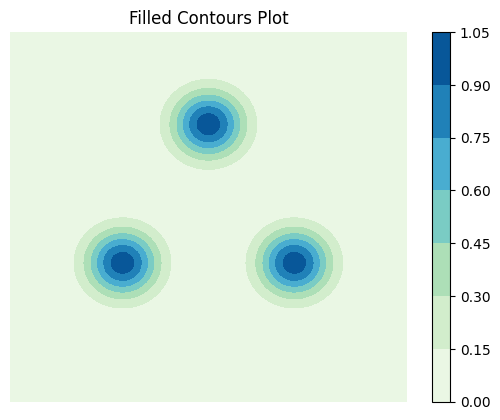

In [7]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.axis('off')
plt.show()

In [8]:
N_samples = 100
N_particles = 3
gamma = 1.0
N_steps_mala = 3
sigma_isir = 4.0

### sample i-sir
Samples_isir = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
np.random.seed(42)
for i in range(N_samples):
    x_cur = i_sir(x_cur,N_particles,sigma_isir)
    Samples_isir[i] = x_cur

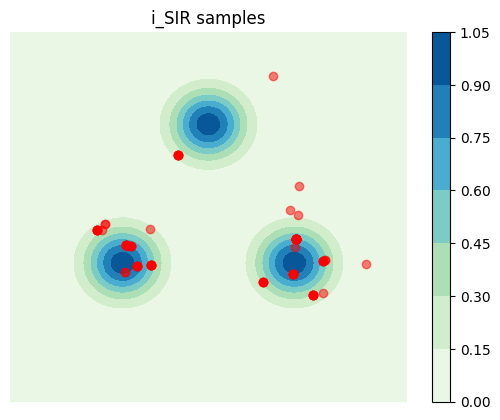

In [9]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_isir[:,0],Samples_isir[:,1], color='r', alpha=0.5)
ax.set_title('i_SIR samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.axis('off')
plt.show()

In [10]:
### sample mala
Samples_mala = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
n_accepts = 0
np.random.seed(42)

for i in range(N_samples):
    x_cur = mala(x_cur,gamma,N_steps_mala)
    Samples_mala[i] = x_cur
print("number accepts = ",n_accepts)

number accepts =  191


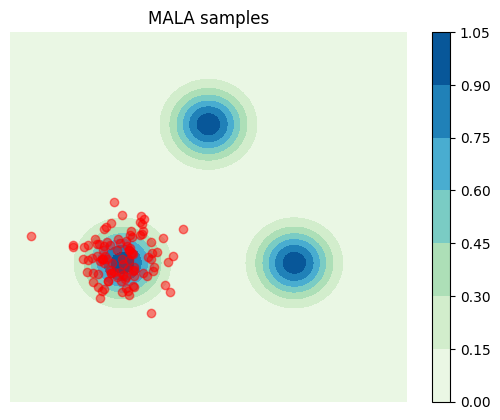

In [11]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_mala[:,0],Samples_mala[:,1], color='r', alpha=0.5)
ax.set_title('MALA samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.axis('off')
plt.show()

In [12]:
### sample ex2mcmc
Samples_ex2 = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
n_accepts = 0
np.random.seed(42)

for i in range(N_samples):
    x_cur = ex2_mcmc(x_cur,N_particles,sigma_isir,gamma,N_steps_mala)
    Samples_ex2[i] = x_cur
print("number accepts = ",n_accepts)

number accepts =  196


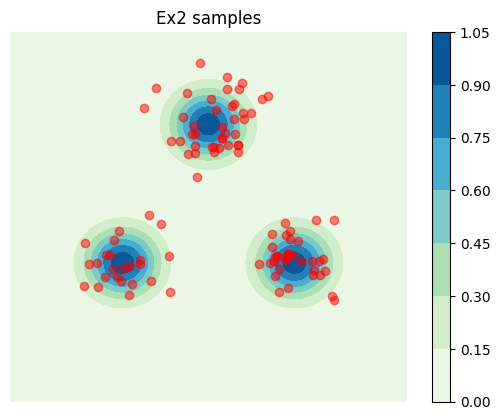

In [13]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals, cmap='GnBu')
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_ex2[:,0],Samples_ex2[:,1], color='r', alpha=0.5)
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.axis('off')
plt.show()

### Plot all 3 pictures together

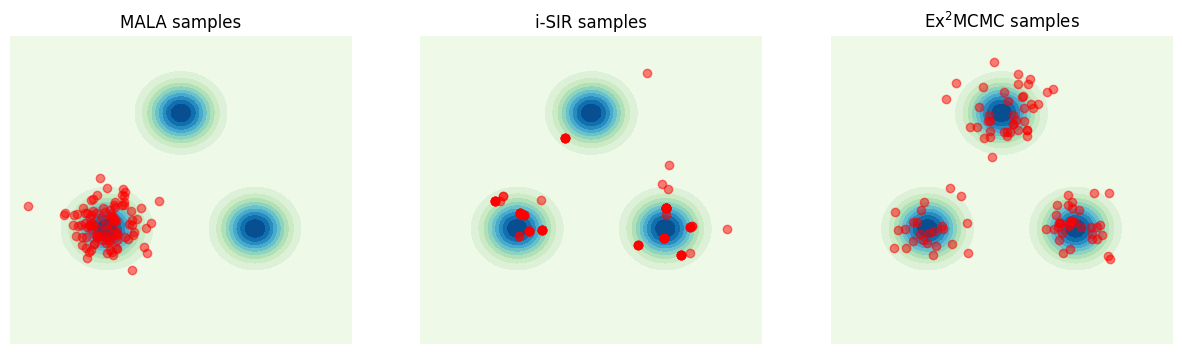

In [17]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
# im = ax[0].contourf(X, Y, dens_vals, cmap='GnBu')
# im = ax[1].contourf(X, Y, dens_vals, cmap='GnBu')
# im = ax[2].contourf(X, Y, dens_vals, cmap='GnBu')
for na, ax in enumerate(axs):
    plt.sca(ax)
    plt.contourf(X, Y, dens_vals, 10, cmap='GnBu')
    plt.axis('off')
        
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
        
# fig.colorbar(im, ax=axs.flat) # Add a colorbar to a plot
#mala samples
axs[0].scatter(Samples_mala[:,0],Samples_mala[:,1], color='r', alpha=0.5)
axs[0].set_title('MALA samples')
#i-sir plots
axs[1].scatter(Samples_isir[:,0],Samples_isir[:,1], color='r', alpha=0.5)
axs[1].set_title('i-SIR samples')
#ex2-mcmc samples
axs[2].scatter(Samples_ex2[:,0],Samples_ex2[:,1], color='r', alpha=0.5)
axs[2].set_title('Ex$^2$MCMC samples')

# plt.savefig("toy_samples_2d_gaus.pdf", format="pdf", bbox_inches="tight") 
plt.show()

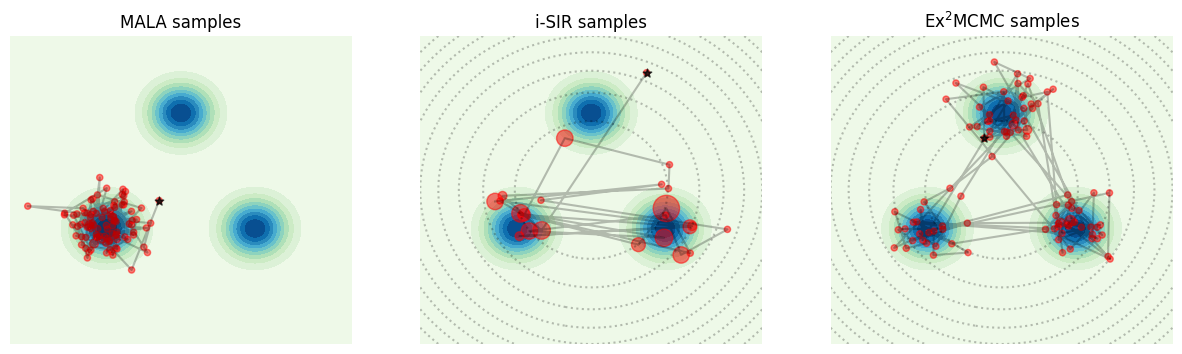

In [16]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
prop_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
        prop_vals[i,j] = log_dens_isir(points[:,i,j], sigma_isir)

for na, ax in enumerate(axes):
    plt.sca(ax)
    plt.contourf(X, Y, dens_vals, 10, cmap='GnBu')
    plt.axis('off')
    if na > 0:
        plt.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
## to do equal ratio

# plt.title(title)
    
# plt.colorbar()
# plt.plot(xs[:, 0, 0], xs[:, 0, 1], 'o', c='r', alpha=0.25, ms=2.5)
chainss = [Samples_mala, Samples_isir, Samples_ex2]
titles = ['MALA samples', 'i-SIR samples', 'Ex$^2$MCMC samples']
for ax, chains, title in zip(axes, chainss, titles):
    plt.sca(ax)
    plt.title(title)
    xs = torch.tensor(chains, dtype=torch.float)
    posx, invx, countsx = torch.unique_consecutive(xs[:, 0], return_counts=True, return_inverse=True)

    posy, invy, countsy = torch.unique_consecutive(xs[:, 1], return_counts=True, return_inverse=True)

    plt.plot(xs[:, 0], xs[:, 1], '-', c='k', alpha=0.25)
    plt.scatter(posx, posy, marker='o', c='r', alpha=0.5, s=countsx*20)
    plt.scatter(xs[0,0], xs[0,1],  marker='*', c='k', alpha=0.75, s=40)
#plt.show()
# plt.savefig('toy_samples_2d_gaus.pdf', format="pdf", bbox_inches="tight")
plt.show()